In [28]:
from networks.MPN import MPN_simplenet, MaskEmbdMultiMPN
from datasets.PowerFlowData import PowerFlowData
from torch_geometric.loader import DataLoader
from utils.evaluation import load_model
from utils.explanation import explain_epoch
from utils.custom_loss_functions import Masked_L2_loss
import torch
import matplotlib.pyplot as plt
import networkx as nx

In [13]:
run_id = '20230627-9288' # mse, or 20230627-5949, mixed
data_dir = '/home/nlin/data/volume_2/power_flow_dataset'
grid_case = '118v2'
batch_size = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MaskEmbdMultiMPN(
    nfeature_dim=6,
    efeature_dim=5,
    output_dim=6,
    hidden_dim=129,
    n_gnn_layers=4,
    K=3,
    dropout_rate=0.2
)
model.eval()
model, _ = load_model(model, run_id, device)

eval_loss_fn = Masked_L2_loss(regularize=False).to(device)

testset = PowerFlowData(root=data_dir, case=grid_case,
                            split=[.00, .00, 1.], task='test')
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)


torch.Size([2950000, 9])
Data(x=[2950000, 9], edge_index=[2, 4650000], edge_attr=[4650000, 5], y=[2950000, 8])


In [29]:
explain_epoch(model, test_loader, eval_loss_fn, 'cpu', samples=2)

  0%|          | 0/25000 [00:00<?, ?it/s]


IndexError: index 0 is out of bounds for dimension 1 with size 0

In [24]:
means, stds, subgraph_nnodes, node_hop_data, nx_G = explain_epoch(model, val_loader, eval_loss_fn, 'cpu', samples=2)

  0%|          | 0/25000 [00:00<?, ?it/s]


IndexError: index 0 is out of bounds for dimension 1 with size 0

subgsize,nidx
1636 	 36
1638 	 23
1652 	 29
1657 	 41
1664 	 46
1670 	 79
1675 	 80
1676 	 65
1679 	 69
1687 	 74
1699 	 37
1702 	 76
1718 	 48
1725 	 64
1729 	 67
1744 	 68


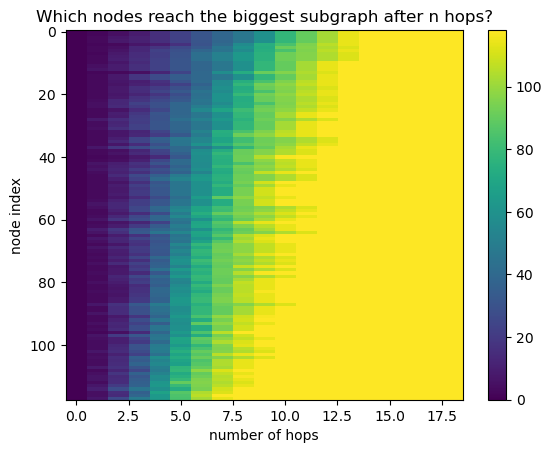

In [4]:
sorted, indices = torch.sort(subgraph_nnodes[:,1:].sum(dim=1))

plt.title("Which nodes reach the biggest subgraph after n hops?")
plt.rcParams["figure.figsize"] = (10,5)
plt.imshow(subgraph_nnodes[indices], interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xlabel('number of hops')
plt.ylabel('node index')

# print worst ones
worst = [(int(x1), int(x2)) for x1, x2 in list(zip(subgraph_nnodes[:,1:].sum(dim=1)[indices], indices))]
print('subgsize,nidx')
[print(x[0], "\t", x[1]) for x in worst[-16:]]
pass


tensor([   nan, 1.3321, 0.8172, 0.6463, 0.6422, 0.6602, 0.6634, 0.6359, 0.6620,
        0.6573, 0.6334, 0.6488, 0.6048, 0.6549, 0.6802, 0.6248, 0.6277, 0.6372,
        0.6676])


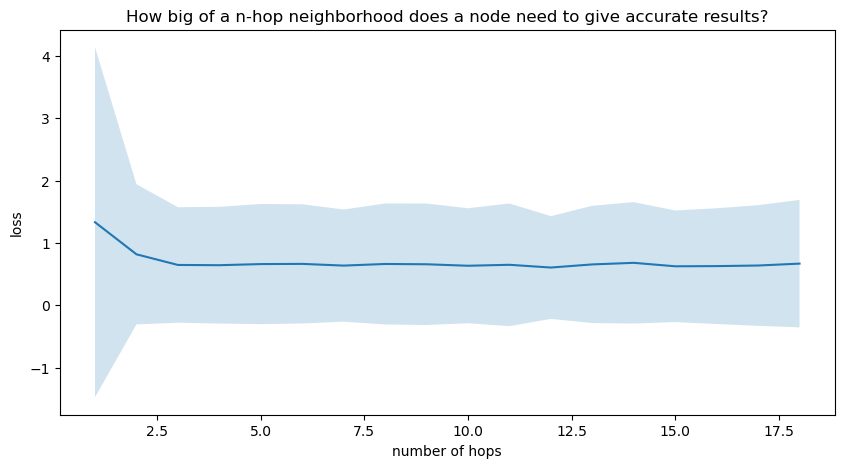

In [5]:
plt.plot(range(means.shape[0]), means)
plt.fill_between(range(means.shape[0]), means - stds, means + stds, alpha=0.2)
plt.title("How big of a n-hop neighborhood does a node need to give accurate results?")
plt.xlabel('number of hops')
plt.ylabel('loss')
print(means)

loss,    nidx
25 	 10
26 	 78
27 	 64
35 	 1
36 	 79
38 	 77
43 	 58
46 	 65
48 	 94
49 	 48
52 	 2
59 	 37
64 	 62
76 	 80
81 	 63
82 	 81


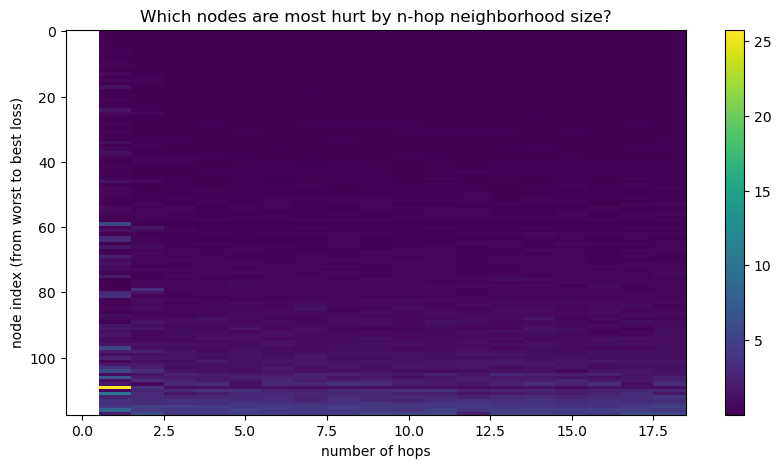

In [6]:
sorted, indices = torch.sort(node_hop_data[:,1:].sum(dim=1))

plt.title("Which nodes are most hurt by n-hop neighborhood size?")
plt.rcParams["figure.figsize"] = (10,5)
plt.imshow(node_hop_data[indices], interpolation='nearest', aspect='auto')
plt.xlabel('number of hops')
plt.ylabel('node index (from worst to best loss)')
plt.colorbar()

# print worst ones
worst = [(int(x1), int(x2)) for x1, x2 in list(zip(node_hop_data[:,1:].sum(dim=1)[indices], indices))]
print('loss,    nidx')
[print(x[0], "\t", x[1]) for x in worst[-16:]]
pass

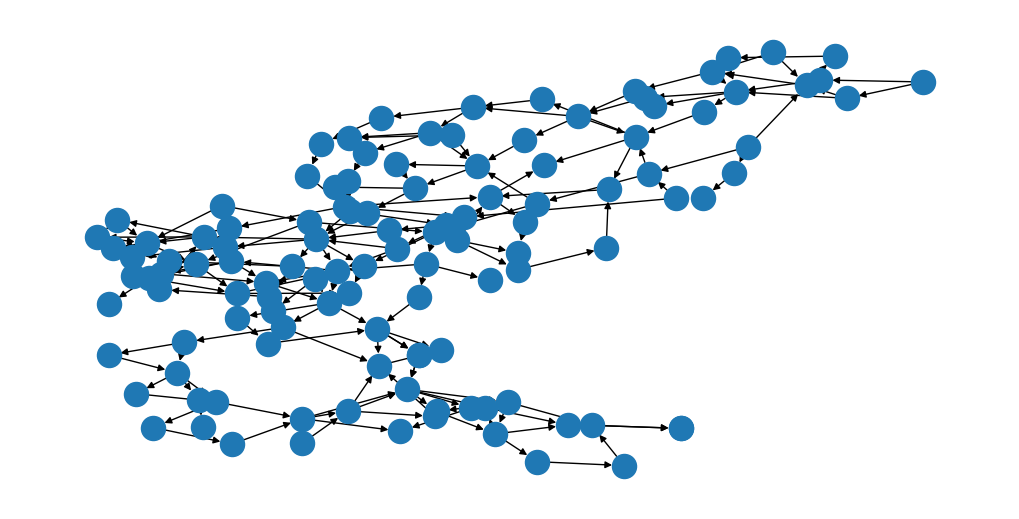

In [7]:
nx.draw_kamada_kawai(nx_G)